In [1]:
import json
import numpy as np
with open('historyCurrency.json') as json_file:
    data = json.load(json_file)

In [2]:
dates =sorted(list(data['rates']))

In [3]:
sample_currencies = ['CAD','HDK','GBP','USD','LTL','CHF','CYP','ZAR','AUD','PLN','EUR'] # HDK, CPP, LTl -niekompletne
subsample_currencies = ['CAD','GBP','USD','CHF','ZAR','AUD','PLN','EUR']

In [4]:
from matplotlib import pyplot as plt

In [5]:
currencies_dict = {curr : [] for curr in subsample_currencies}
for d in dates:
    for curr in subsample_currencies:
        currencies_dict[curr].append(data['rates'][d][curr])

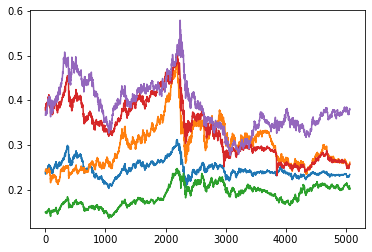

In [6]:
# plt.plot(range(len(dates)),currencies_dict['PLN'])
plt.plot(range(len(dates)),currencies_dict['EUR'], label ='EUR')
plt.plot(range(len(dates)),currencies_dict['USD'], label ='USD')
plt.plot(range(len(dates)),currencies_dict['GBP'], label ='GBP')
plt.plot(range(len(dates)),currencies_dict['CHF'], label ='CHF')
plt.plot(range(len(dates)),currencies_dict['AUD'], label ='AUD')

plt.show()

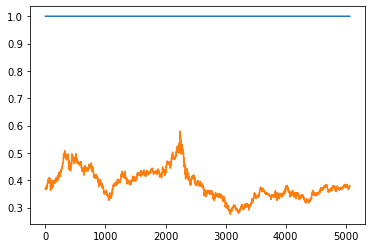

In [43]:
plt.plot(range(len(dates)),currencies_dict['PLN'])
plt.plot(range(len(dates)),currencies_dict['AUD'])

plt.show()

In [7]:
def _dummy_create_windows(ds, x_len, y_len):
    total_len = x_len+y_len
    return [(ds[i*total_len:i*total_len + x_len],ds[i*total_len+ x_len:i*total_len + x_len+y_len])
           for i in range(len(ds)//total_len)]

In [86]:
def windows(ds, x_len, y_len):
    total_len = x_len+y_len
    return [(ds[i:i+x_len],ds[i+x_len:i+x_len+y_len])
           for i in range(len(ds)-total_len)]

def shifted_windows(ds, x_len, y_shift):
    total_len = x_len+y_shift
    return [(ds[i:i+x_len],ds[i+x_len+y_shift])
           for i in range(len(ds)-total_len)]

train_to_test_ratio = 0.8
def prepare_dataset(ds, x_len, y_len,train_to_test_ratio = 0.8,window=windows):
    division_point = int(len(ds) * train_to_test_ratio)
    train = ds[:division_point]
    test = ds[division_point:]
    x_train,y_train = zip(*window(train,x_len, y_len))
    x_test,y_test = zip(*window(test,x_len, y_len))
    return  np.asarray(x_train).reshape((len(x_train),x_len)), \
            np.asarray(x_test).reshape((len(x_test),x_len)),   \
            np.asarray(y_train).reshape((len(y_train),1)),\
            np.asarray(y_test).reshape((len(y_test),1))
    

In [9]:
x_train,x_test,y_train,y_test = prepare_dataset(currencies_dict['AUD'],10,1)

In [10]:
from sklearn.metrics import mean_absolute_error

def dummy_fit_predict(x_train,y_train,x_test,y_test):
    from xgboost import XGBRegressor

    my_model = XGBRegressor()
    my_model.fit(x_train, y_train, verbose=True)
    predictions = my_model.predict(x_test)

    print("Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))
    return predictions

Mean Absolute Error : 0.00190788632692


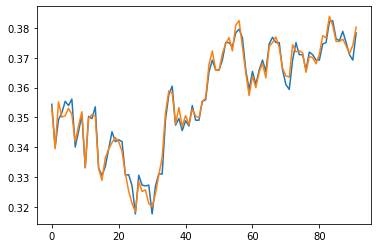

In [70]:
plt.plot(range(len(x_test)),predictions)
plt.plot(range(len(y_test)),y_test)

^ bad windowing above. NOne overlapping days

In [16]:
x_train,x_test,y_train,y_test = prepare_dataset(currencies_dict['AUD'],10,1)
predictions = dummy_fit_predict(x_train,y_train,x_test,y_test).reshape(-1,1)

[21:03:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error : 0.00158148228117


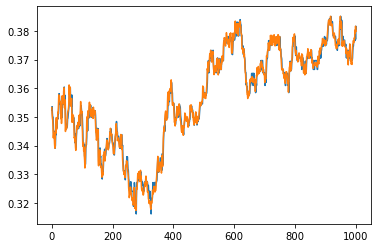

In [92]:
plt.plot(range(len(x_test)),predictions)
plt.plot(range(len(y_test)),y_test)
plt.show()

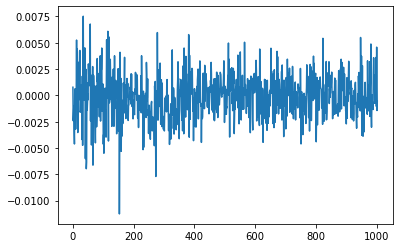

In [96]:
plt.plot(range(len(x_test)), y_test - predictions) # porównać z różnicą wartości między poszczególnymi dniami!!

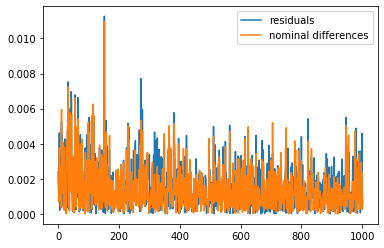

In [122]:
plt.plot(range(len(x_test)-1), np.abs(y_test[1:] - predictions[1:]), label='residuals') # porównać z różnicą wartości między poszczególnymi dniami!!
plt.plot(range(len(x_test)-1), np.abs(y_test[1:] - y_test[:-1]), label='nominal differences')
plt.legend(loc='upper right')
plt.show()

zmiany pomiędzy dniem X i X+1 są porównywalne do odległości predykcji i stanu faktycznego, co nie wróży zbyt dobrze naszym predykcjom.

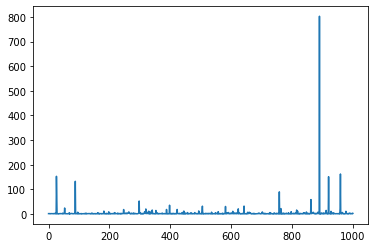

In [124]:
plt.plot(range(len(x_test)-1), (np.abs(y_test[1:] - predictions[1:]) / np.abs(y_test[1:] - y_test[:-1])))
plt.show()

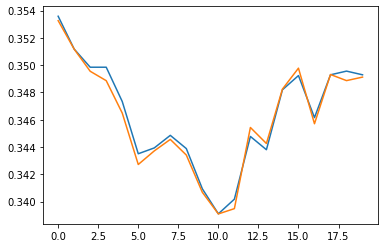

In [48]:
plt.plot(range(20),predictions[1:21])
plt.plot(range(20),y_test[0:20])
plt.show()

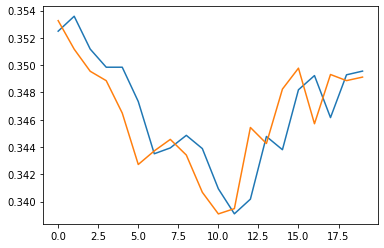

In [130]:
plt.plot(range(20),predictions[0:20])
plt.plot(range(20),y_test[0:20])
plt.show()

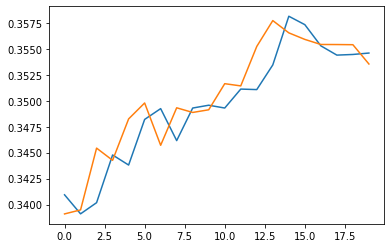

In [131]:
plt.plot(range(20),predictions[10:30])
plt.plot(range(20),y_test[10:30])
plt.show()

Wyraźnie widać, że model "spóźnia się o dzień" -  w zasadzie jedyne co robi to kopiuje zachowanie kursu z dnia poprzedniego na kolejny dzień. DObrze to widać na wykresie, gdzie predykcje zostały przesunięte o 1 dzień do przodu. Wtedy okazuje się, że model jest niemal idealny.
Spóźnienia dobrze widać na pierwszych próbkach

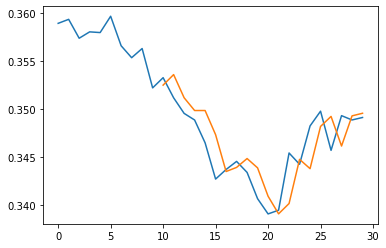

In [46]:
ds = currencies_dict['AUD']
division_point = int(len(ds) * train_to_test_ratio)

plt.plot(range(30),currencies_dict['AUD'][division_point:division_point+30])
plt.plot(range(10,30),predictions[:20])
plt.show()
# nałożenie predykcji na wizualizację wartosci ze zbioru testowego

In [82]:
def dummy_model(model,ds,x_len=10,y_len=1,window=windows):
    x_train,x_test,y_train,y_test = prepare_dataset(ds,x_len,y_len,window = window)
    
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)

    return model,predictions,mean_absolute_error(predictions, y_test)
    

In [63]:
from xgboost import XGBRegressor

xgRegressor = XGBRegressor()

In [87]:
windows_scores = [dummy_model(xgRegressor,currencies_dict['AUD'],i,1)[2] for i in [3,5,7,10,13,15,20,25,50,100]]

[22:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:29:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

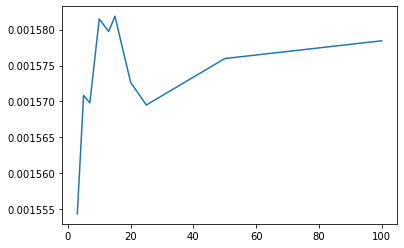

In [79]:
plt.plot([3,5,7,10,13,15,20,25,50,100], windows_scores)

In [77]:
import seaborn as sns

In [90]:
windows_scores_2D = [[dummy_model(xgRegressor,currencies_dict['AUD'],i,j,shifted_windows)[2] for i in [1,3,5,7,10,13,15,20,25,50,100]] for j in [1,2,3,4,5,7,9,10]]

[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

[22:35:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost

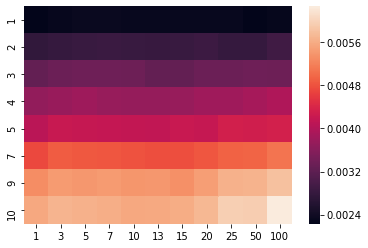

In [95]:
x_axis_labels = [1,3,5,7,10,13,15,20,25,50,100] # labels for x-axis
y_axis_labels = [1,2,3,4,5,7,9,10] # labels for y-axis
sns.heatmap(windows_scores_2D,xticklabels=x_axis_labels, yticklabels=y_axis_labels)

powyższy wykres pokazuje, że próba przewidywania bezpośrednio kilka dni do przodu najpewniej zakończy się niepowodzeniem. Pokazuje jednak również, że predykcje wyżej nie były aż tak tragiczne, bo "zawsze może być gorzej" - np gdy spróbujemy przewidzieć za dużo do prozdu na raz

In [ ]:
# Klasyfikacja - nastepnego dnia wyzej, czy nizej?

In [144]:
def simple_regression_to_classification_ds(x_train,y_train,x_test,y_test):
    return  x_train, \
            (x_train[:,-1].reshape((-1,1)) < y_train).astype(np.float32),\
            x_test,\
            (x_test[:,-1].reshape((-1,1)) < y_test).astype(np.float32)

In [145]:
x_train_c,y_train_c,x_test_c,y_test_c = simple_regression_to_classification_ds(x_train,y_train,x_test,y_test)

In [162]:
from sklearn.metrics import accuracy_score
def simple_model(model,ds,window_len=10,shift_len=1,window=shifted_windows):
    x_train,x_test,y_train,y_test = prepare_dataset(ds,window_len,shift_len,window = window)
    x_train_c,y_train_c,x_test_c,y_test_c = simple_regression_to_classification_ds(x_train,y_train,x_test,y_test)
    
    model.fit(x_train_c, y_train_c)
#     print(x_train_c[:10,:].shape)
#     print(y_train_c[:10])
#     print(x_test_c[:10,:].shape)
#     print(y_test_c[:10])

    predictions = model.predict(x_test_c)
    return model,predictions,accuracy_score(predictions,y_test_c)

In [172]:
from xgboost import XGBClassifier
res =simple_model(model = XGBClassifier(),ds=currencies_dict['AUD'],window_len=10)

/home/robert/miniconda3/envs/particles/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/robert/miniconda3/envs/particles/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [189]:
from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings("ignore", category=DataConversionWarning)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

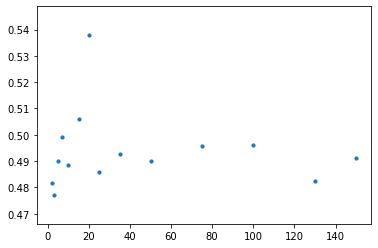

In [184]:

window_sizes = [2,3,5,7,10,15,20,25,35,50,75,100,130,150]
window_scores = [simple_model(model = XGBClassifier(),ds=currencies_dict['AUD'],window_len=i)[2] for i in window_sizes]

plt.scatter(window_sizes,window_scores,s=10)
plt.show()

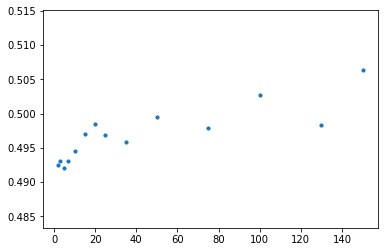

In [196]:
# Lets try an SVM
from sklearn.svm import SVC
window_scores = [simple_model(model = SVC(kernel='linear'),ds=currencies_dict['AUD'],window_len=i)[2] for i in window_sizes]

plt.scatter(window_sizes,window_scores,s=10)
plt.show()

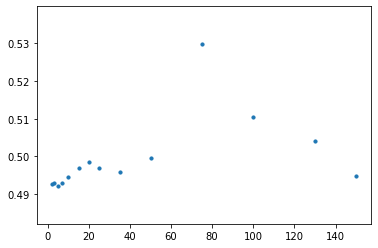

In [193]:
# Lets try an SVM
from sklearn.svm import SVC
window_scores = [simple_model(model = SVC(kernel='rbf',gamma=0.1),ds=currencies_dict['AUD'],window_len=i)[2] for i in window_sizes]

plt.scatter(window_sizes,window_scores,s=10)
plt.show()

[11:08:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1566327313563/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


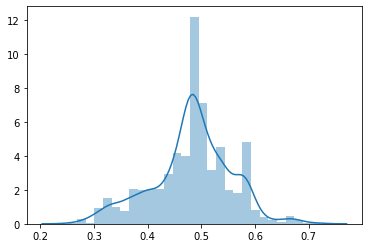

In [211]:
import seaborn as sns
m= XGBRegressor()
ds = currencies_dict['AUD']
window_len=20
x_train,x_test,y_train,y_test = prepare_dataset(ds,window_len,1,window = shifted_windows)
x_train_c,y_train_c,x_test_c,y_test_c = simple_regression_to_classification_ds(x_train,y_train,x_test,y_test)
    
m.fit(x_train_c, y_train_c)
prediction = m.predict(x_test_c)

sns.distplot(prediction)

wykres wyzej pokazuje w pewnym sensie niepewnosc modelu. WIekszosc wartosci oscyluje w okolicach 0.5

In [215]:
from collections import defaultdict
splitted = defaultdict(list)
for date, rates in data['rates'].items():
    splitted[date[:4]].append((date,rates['AUD']))
for key in splitted.keys():
    splitted[key] = [a[1] for a in sorted(splitted[key],key=lambda x: x[0])]


[0.366822039, 0.369540108, 0.3700236939, 0.3716103585, 0.375635487, 0.374984964, 0.3750239418, 0.3741425054, 0.3700421537, 0.3679827193]


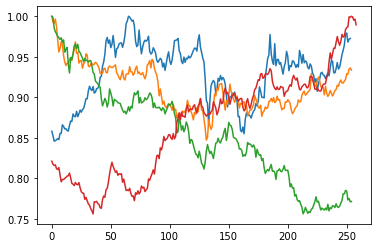

In [225]:
for key in ['2001','2002','2003','2004']:
    val = splitted[key]
    plt.plot(range(len(val)),np.array(val)/np.max(val), label = key)
# plt.legend(loc='upper right')

plt.show()

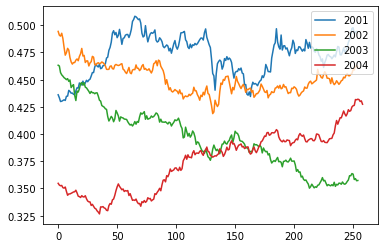

In [230]:
for key in ['2001','2002','2003','2004']:
    val = splitted[key]
    plt.plot(range(len(val)),np.array(val), label = key)
plt.legend(loc='upper right')

plt.show()

In [227]:
#window 20 when this is running
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(x_train_c, y_train_c)
        y_pred = model.predict(x_test_c)
        score = accuracy_score(y_test_c, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.522658610272 at depth of 1 and estimator 150
Score is 0.497482376636 at depth of 2 and estimator 150
Score is 0.538771399799 at depth of 3 and estimator 150
Score is 0.522658610272 at depth of 4 and estimator 150
Score is 0.521651560926 at depth of 5 and estimator 150
Score is 0.492447129909 at depth of 6 and estimator 150
Score is 0.488418932528 at depth of 7 and estimator 150
Score is 0.511581067472 at depth of 8 and estimator 150
Score is 0.520644511581 at depth of 9 and estimator 150
Score is 0.498489425982 at depth of 10 and estimator 150
Score is 0.511581067472 at depth of 11 and estimator 150
Score is 0.4944612286 at depth of 12 and estimator 150
Score is 0.51863041289 at depth of 1 and estimator 200
Score is 0.4944612286 at depth of 2 and estimator 200
Score is 0.523665659617 at depth of 3 and estimator 200
Score is 0.51863041289 at depth of 4 and estimator 200
Score is 0.515609264854 at depth of 5 and estimator 200
Score is 0.

In [97]:
#TODO

# (ewentualnie jakos usredniać wartości z różnych długości okien)
# pomyśleć nad algo klasyfikacji "kupić, sprzedać czy trzymać"
# moze sprobowac nakladania okien z roznymi usrednionymi wartosciami?
# wyprobowac drugie api

NameError: name 'xgboost' is not defined

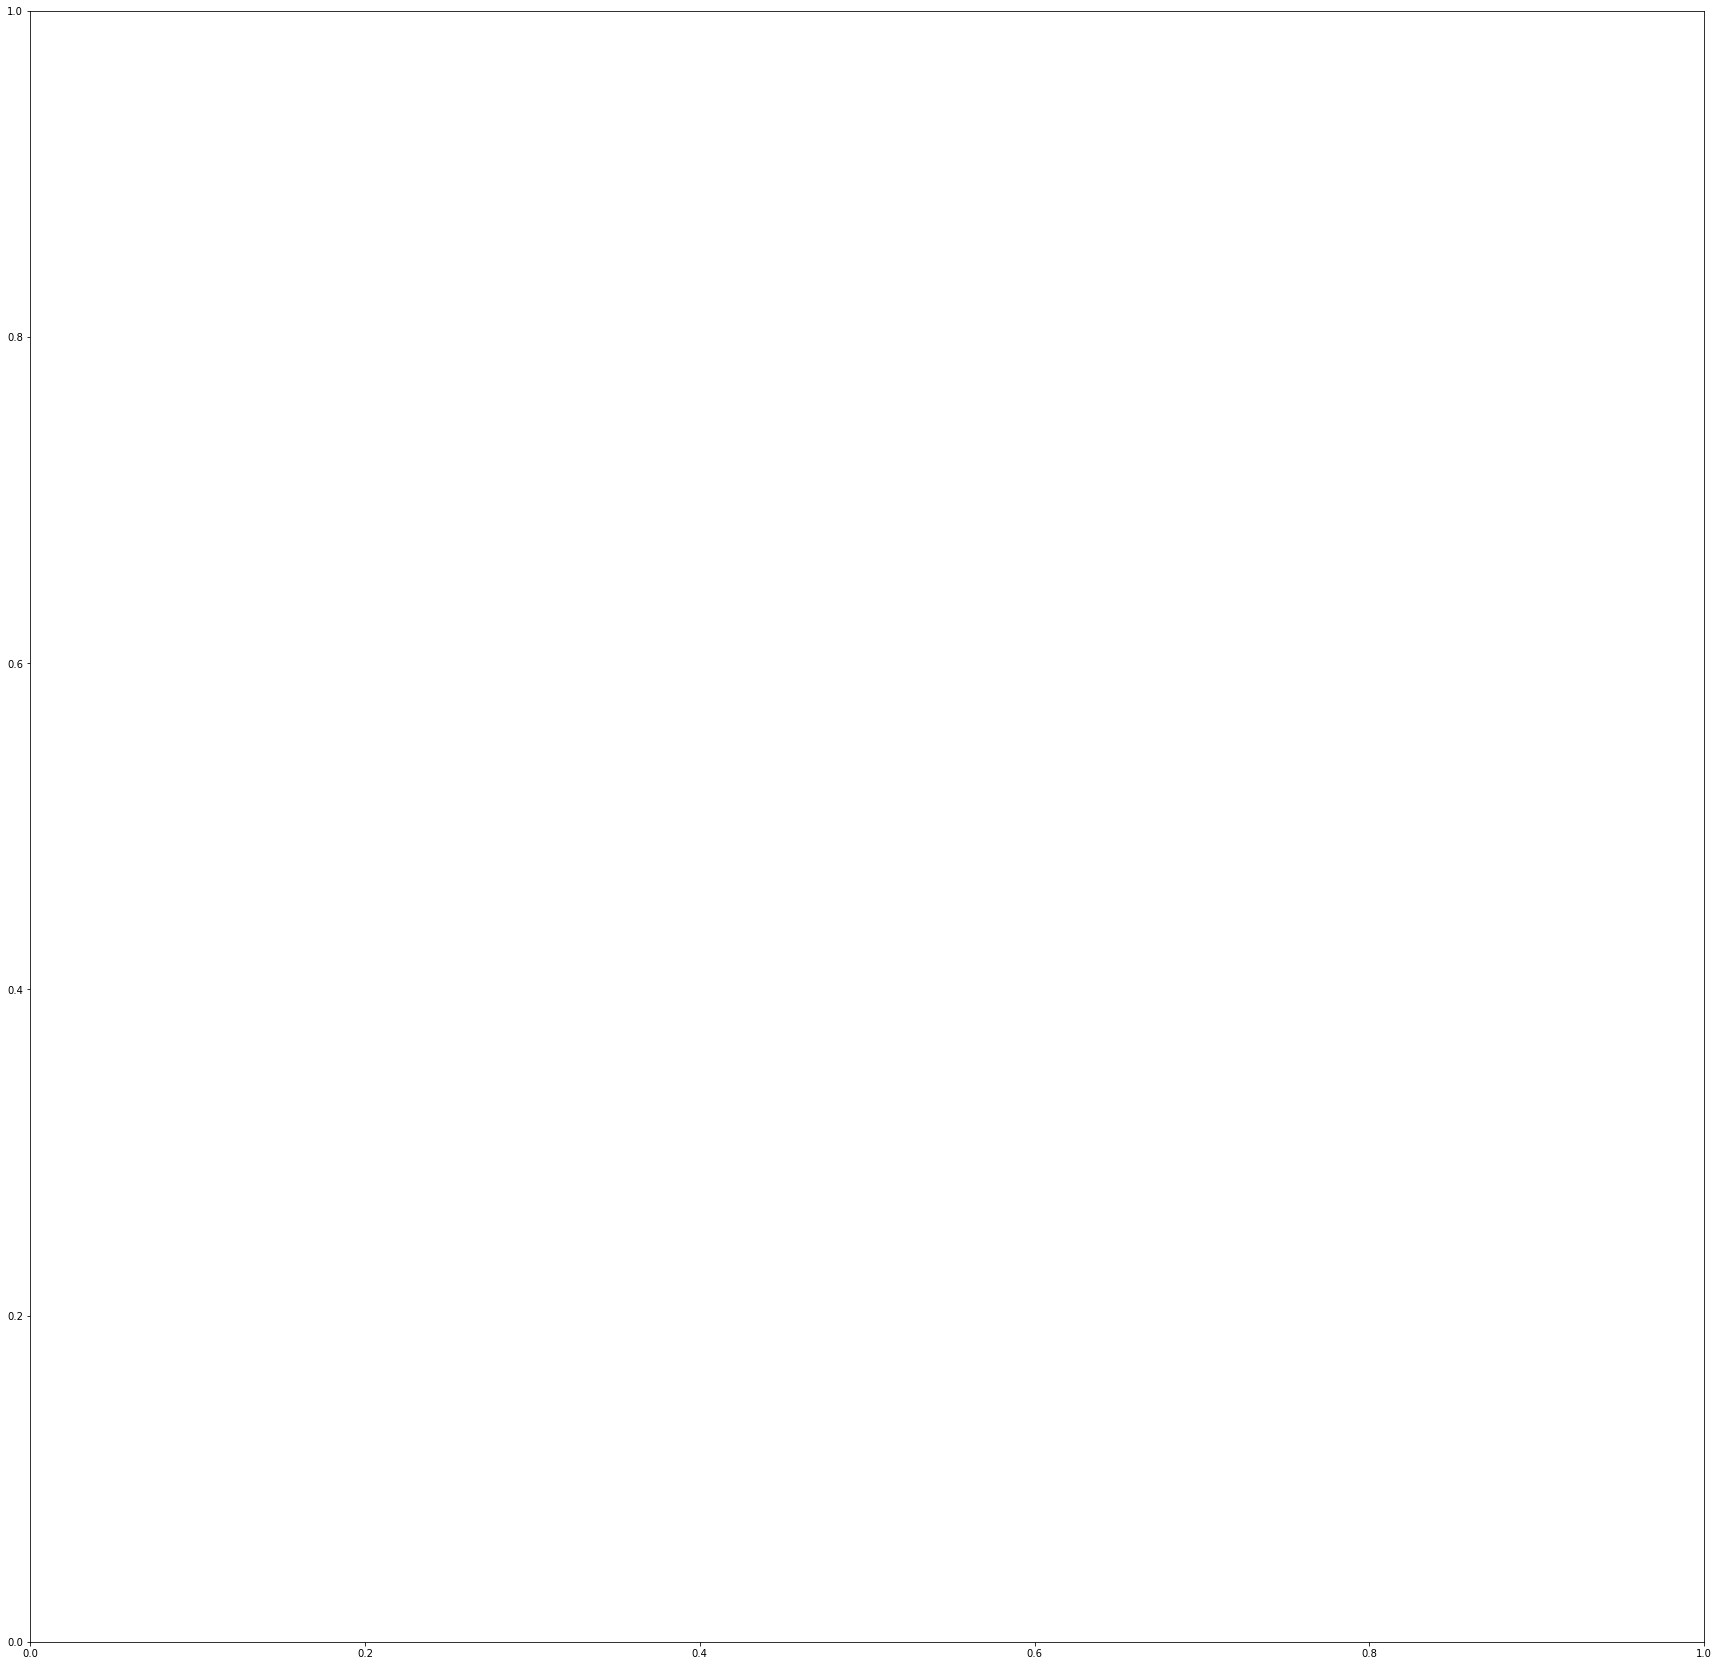

In [229]:
model = XGBClassifier(n_estimators=n, max_depth=md)
model.fit(x_train_c, y_train_c)

fig, ax = plt.subplots(figsize=(30, 30))
xgboost.plot_tree(model, num_trees=4, ax=ax)
plt.show()


array([1, 3])